In [1]:
# Original file name: tis.ipynb from Rare Event Summer School in Dropbox
# New file name: (RE)TIS-Code.ipynb
# Last Modified by Porhouy (PH) Minh
# Last Updated Date: 05-11-2023 
# SAMPEL Group

## RETIS Tutorial


- This code will perform transition interface sampling (TIS) on a simple potential energy surface (PES) with the replica exchange (RE) move --> "RETIS". 

- The code is constructed as follows: 

    - Choosing your PES

    - Deciding on your simulation settings

    - Run equilibration and basin simulation 

    - Generate an initial path at a higher temperature

    - Perform RETIS on your selected PES at your desired temperature

    - Perform sampling quality checks

        - Calculate running average of the crossing probability for each interface

        - Construct autocorrelation graphs for paths in each interface ensemble 

        - Construct the crossing probability histogram for each interface
    
    - Perform a continuation for RETIS (as needed)
    
    - Visualize the paths for each interface ensemble

    - Calculate rate for the event (A --> B)

        - Calculate flux through the first interface

        - Calculate the crossing probability

## Learning Objectives

1. Understand what a replica exchange (RE) move is in transition interface sampling (TIS).  

    - How is RETIS different from TIS?  
    </br>

2. Explore the importance of interface placement and interface type on a given potential energy surface (PES).
    * To do this exploration, you can modify the following variables in the code:

        - **pes_type**: this will change the PES that you use for your simulation 

        - **op_type**: this will change the form of your op. The options provided are op_type = x, y, or x+y

        - **interfaces values** in the interface list: this will change where you place your interface

        - **basinA; basinB**: this will change where you define your basin(s) on the PES

        - **init_coords**: this will change where you start on your PES in your simulation

        - **beta**: this will change the temperature since beta = 1/(k_B*T), which consequently also changes the PES barrier height due to the change in temperature (T)

    * Questions to think about while exploring: 

        - How does changing variables related to the PES/my system (like pes_type, beta, basinA, basinB) impact my sampling?
        
        - How does changing variables related to RETIS methodology (like op_type, interfaces values, init_coords) impact my sampling?

3. Understand the procedure in RETIS sampling and the reason behind these steps that we follow for performing a RETIS "simulation".

    - Why do we need to run an intial simulation at a higher temperature?

</br>
        
4. Gain knowledge of sampling checks for RETIS work and understand what information each sampling check provide about our system.

    - What does "running average crossing probability of each interface" tell you about your sampling? 

    - What does "autocorrelation functions/graphs" tell you about your sampling? 

    - What does "the crossing probability histogram" tell you about your sampling? 
    
    - How will you decide how many more moves to run your RETIS?

## Energy surface contours options

PES-1: $$ V(x,y) = 0.02(x^4+y^4) - 4\exp(-(x+2)^2 - (y+2)^2) - 4\exp(-(x-2)^2 - (y-2)^2) + 0.3(x-y)^2 + 0.0026 $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-1.png"> 

PES-2: $$ V(x,y) = 0.03(x^4+y^4) - 4\exp(-(x+2)^2 - (y+2)^2) - 4\exp(-(x-2)^2 - (y-2)^2) + 0.4(x-y)^2 + 4\exp(-(x^2+y^2)) - 2.1245 $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-2.png">

PES-3: $$ V(x,y) = 0.02(x^4+y^4) - 3.73\exp(-\frac{(x+2)^2}{8} - \frac{(y+2)^2}{8}) - 3.73\exp(-\frac{(x-2)^2}{8} - \frac{(y-2)^2}{8}) + 3\exp(-\frac{x^2}{2} - \frac{y^2}{15}) + 2\exp(-\frac{x^2}{2} - \frac{y^2}{2}) - 0.5085 $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-3.png">

PES-4: Müller-Brown Potential 
$$ V_{MB}(x,y) = \sum_{i=1}^{4}{A_{i}\exp([ a_{i}(x-\bar{x_{i}})^2 + b_{i}(x-\bar{x_{i}})(y-\bar{y_{i}}) + c_{i}(y-\bar{y_{i}})^2 ])} $$ 
where:

$$ A = [-8, -4, -6.8, 0.6] $$
$$ a = [-0.111, -0.111, -0.722, 0.0778] $$
$$ b = [0, 0, 1.22, 0.0667] $$
$$ c = [-1.11, -1.11, -0.722, 0.0778] $$
$$ \bar{x} = [3, 0, -1.5, -3] $$
$$ \bar{y} = [-3, -1.5, 1.5, 0] $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-4.png">

## Choose your PES

- Here you can plot the PES you want and confirm that is what you want. 

<function matplotlib.pyplot.show(close=None, block=None)>

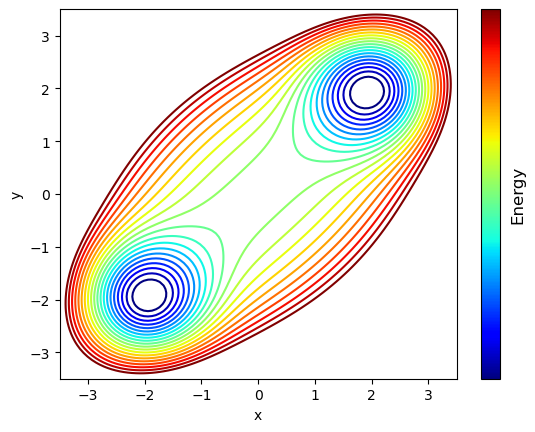

In [2]:
import numpy as np
import sys
import math
import copy
from math import exp
import langevin_dynamics as ld
import random
import time
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
from tqdm import tqdm

# Select your PES type: ***** EDIT HERE *****
pes_type = 1

# Plot potential energy surface contours
N = 100
x_vec = np.linspace(-3.5, 3.5, N)
y_vec = np.linspace(-3.5, 3.5, N)
X, Y = np.meshgrid(x_vec, y_vec)
energy = np.zeros((N, N))

# Plot contours
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(pes_type,x_vec[i],y_vec[j])
plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.xlabel('x')
plt.ylabel('y')
plt.show

## Simulation Settings

- Here you define what op_type you would like to use, where you will place your interfaces, where your basins are, your initial starting configuration (position and momentum) and the temperature of your simulation. 

<function matplotlib.pyplot.show(close=None, block=None)>

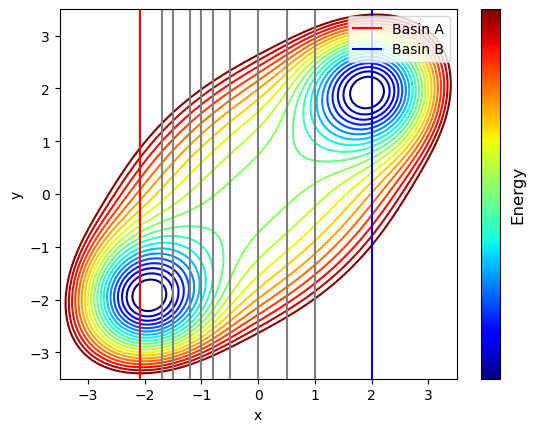

In [3]:
# RETIS settings
n_moves = 1500              # number of moves to perform for each path ensemble - path ensemble corresponding to each diff interface
op_type = 1                 # order parameter;  1:x  2:y  3:x+y

interfaces = [-1.7, -1.5, -1.2, -1, -0.8, -0.5, 0.0, 0.5, 1.0, 2.0]

# interfaces = [0, -0.5, -1, -1.5, -2, -2.5, -3]

basinA = -2.09              # boundary of basin A; must be less than the first interface
# basinA = 1                  # boundary of basin A; must be less than the first interface

basinB = interfaces[-1]     # basin B defined as last interface

init_coords = [-2, -2]      # initial coordinates
# init_coords = [-2, 1]      # initial coordinates

init_p = [0, 0]             # initial momenta
basineqlen = 5000           # basin equilibration length (steps)
basinlen = 50000            # basin simulation length
sigma = 0.5                 # standard deviation of momenta perturbation

# Langevin Dynamics Settings
beta = 2.5                  # 1/kT
gamma = 5.0                 # friction
dt = 0.01                   # time step size



# Plot PES contours with interfaces
# Plot contours
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(pes_type,x_vec[i],y_vec[j])
         
plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

# Plot basin boundaries

if op_type == 1:
    plt.plot(np.linspace(basinA,basinA,10),np.linspace(min(y_vec),max(y_vec),10),color='r', label='Basin A')
    plt.plot(np.linspace(basinB,basinB,10),np.linspace(min(y_vec),max(y_vec),10),color='b', label='Basin B')
elif op_type == 2:
    plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(basinA,basinA,10),color='r', label='Basin A')
    plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(basinB,basinB,10),color='b', label='Basin B')
else:
    xplot = np.linspace(min(x_vec),max(x_vec),10)
    yplmax = basinB - xplot
    yplmin = basinA - xplot
    plt.plot(xplot,yplmin,color='r', label='Basin A')
    plt.plot(xplot,yplmax,color='b', label='Basin B')

# Plot interfaces
for i in range(len(interfaces)-1):
    if op_type == 1:
        plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(min(y_vec),max(y_vec),10), color='grey')
    elif op_type == 2:
        plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(interfaces[i],interfaces[i],10), color='grey')
    else:
        xplot = np.linspace(min(x_vec),max(x_vec),10)
        yplot = interfaces[i]-xplot
        plt.plot(xplot,yplot, color='grey')


cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show


## Equilibration Run

- Here the initial point is being relaxed into basin A.

In [4]:
# Declare array to store basin trajectory
basintraj = np.zeros((basinlen + 1, 6),dtype=float)                             # matrix: each row is the next configuration and each column is x, y, px, py, fx, fy

# Calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma,pes_type)

# Combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]
basintrajeq = ld.vv_step(init_phasepoint,dt,beta,gamma,pes_type)                # use velocity verlet to generate the next configuration of x, y, px, py, fx, fy

# Equilibrate in basin
for i in range(1,basineqlen + 1):
    new_basintrajeq = ld.vv_step(basintrajeq,dt,beta,gamma,pes_type)            # array of x, y, px, py, fx, fy
    basintrajeq = new_basintrajeq
    op = ld.calc_op(op_type,basintrajeq[0],basintrajeq[1])                      #ld.calc_op(op_type, x, y of the trajectory)
    
    # check if trajectory reaches basin B
    
    if pes_type == 4 and op_type == 2:
        if op <= basinB:
            sys.exit("Basin trajectory reached B! Exiting...")
    elif op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")
    


In [5]:
# Visualizing equilibration 

# for i in range(len(x_vec)):
#     for j in range(len(y_vec)):
#         energy[j][i] = ld.potential(pes_type,x_vec[i],y_vec[j])

# plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

# plt.scatter(basintraj[:,0],basintraj[:,1]) 

# cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
# cbar.set_ticks([])
# cbar.set_label(label = 'Energy', size=12)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show


## Run a basin simulation

- Why do we need to run basin simulation?

**[Answer: Edit Text]**

<function matplotlib.pyplot.show(close=None, block=None)>

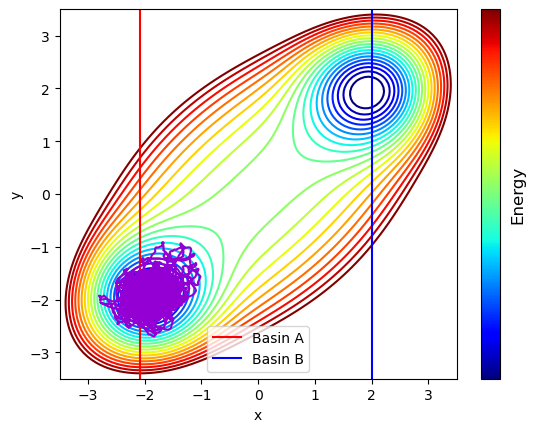

In [6]:
basintraj[0] = basintrajeq                                                      # saving the last configuration from the equilibration run as the first config for prod run
fromBasin = False
n_cross_flux = 0

# Run one basin A simulation and check for first crossings
for j in range(1,basinlen + 1):
    basintraj[j] = ld.vv_step(basintraj[j-1],dt,beta,gamma,pes_type)            # each iteration is a configuration so that basintraj at the end makes a matrix
    op = ld.calc_op(op_type,basintraj[j][0],basintraj[j][1]) 
    
    if pes_type == 4 and op_type == 2:

        if op > basinA:
            fromBasin = True
        
        if fromBasin == True and op <= interfaces[0]: 
            n_cross_flux += 1
            fromBasin = False
    
    else:
        if op < basinA:
            fromBasin = True
        
        if fromBasin == True and op >= interfaces[0]: 
            n_cross_flux += 1
            fromBasin = False
    
    # Check if trajectory reaches basin B  
    if pes_type == 4 and op_type == 2:
        if op <= basinB:
            sys.exit("Basin trajectory reached B! Exiting...")
    elif op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

if n_cross_flux == 0:
    sys.exit("No first crossings obtained from basin A to interface 0. Exiting...")


# Visualizing basin simulation 

for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(pes_type,x_vec[i],y_vec[j])
 
plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

# Plot basin boundaries

if op_type == 1:
    plt.plot(np.linspace(basinA,basinA,10),np.linspace(min(y_vec),max(y_vec),10),color='r', label='Basin A')
    plt.plot(np.linspace(basinB,basinB,10),np.linspace(min(y_vec),max(y_vec),10),color='b', label='Basin B')
elif op_type == 2:
    plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(basinA,basinA,10),color='r', label='Basin A')
    plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(basinB,basinB,10),color='b', label='Basin B')
else:
    xplot = np.linspace(min(x_vec),max(x_vec),10)
    yplmax = basinB - xplot
    yplmin = basinA - xplot
    plt.plot(xplot,yplmin,color='r', label='Basin A')
    plt.plot(xplot,yplmax,color='b', label='Basin B')

# Plot basin path
plt.plot(basintraj[:,0],basintraj[:,1],color='darkviolet') 

cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show


## Generate the initial paths by simulating at a higher temperature

- Why do we need to generate an initial path at a higher temperature? **Bonus**: How do we control the temperature? 

**[Answer: Edit Text]**

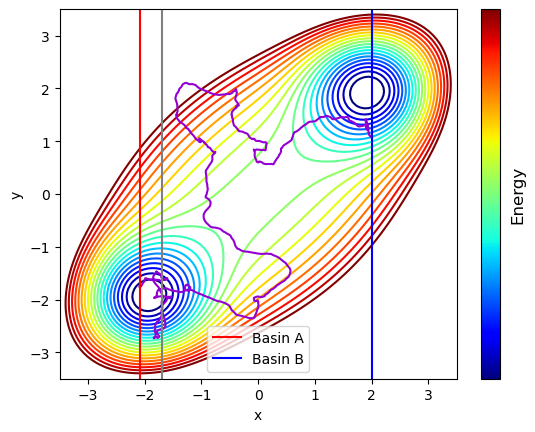

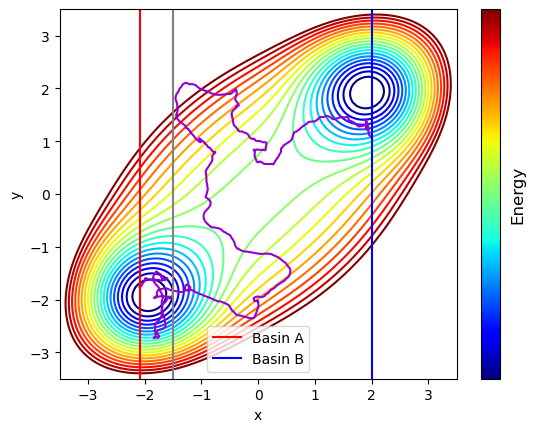

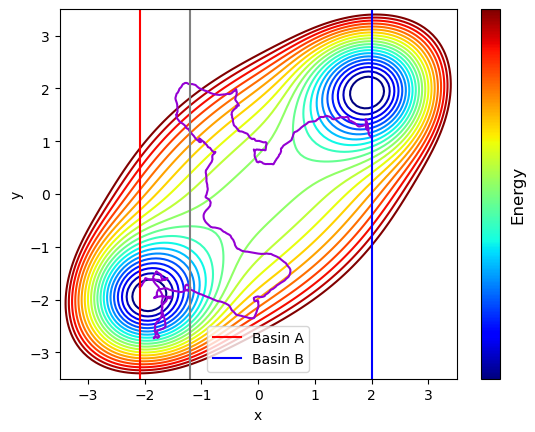

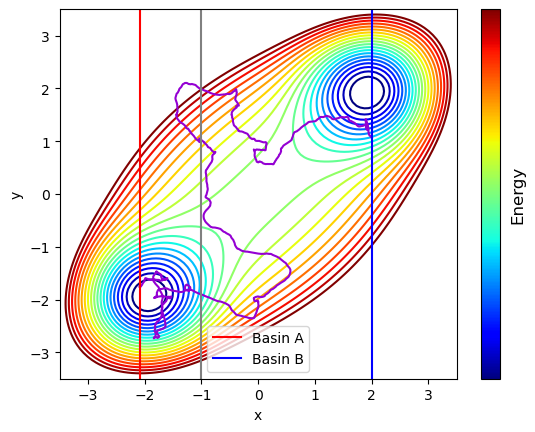

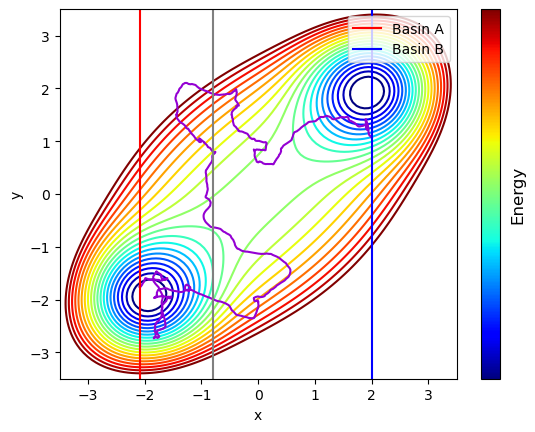

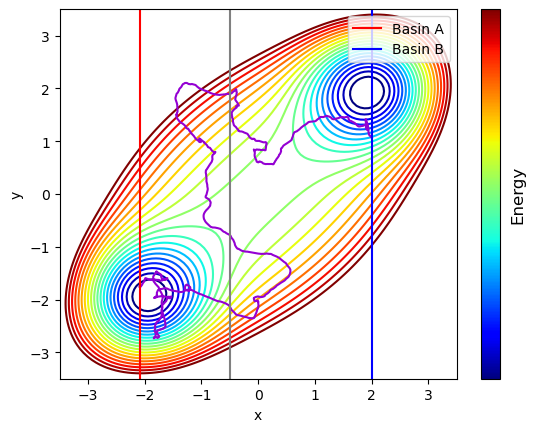

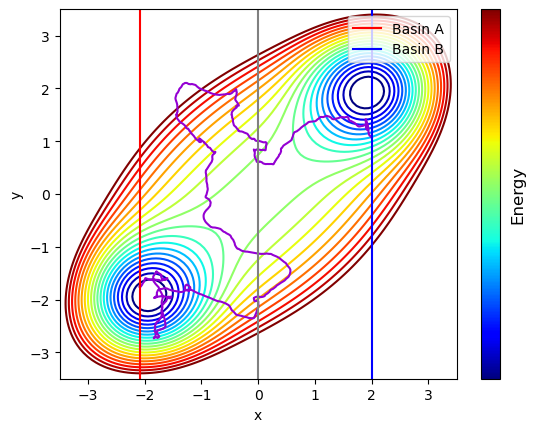

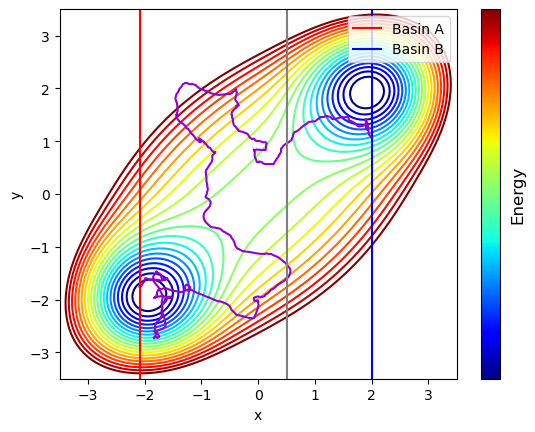

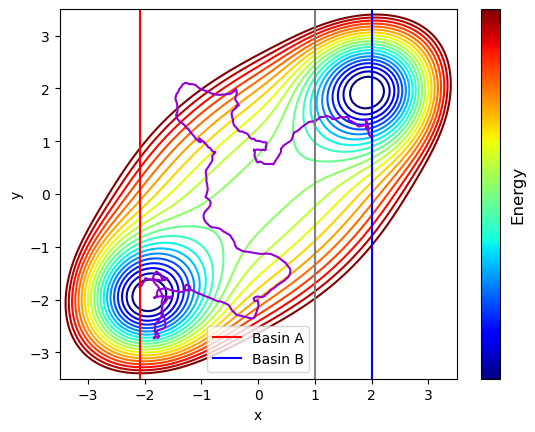

In [7]:
# Run at higher temperature to generate an initial path
initpath = []
beta_initpath = 1.5                                                     # this controls the temperature because beta = 1/kb*T
fromBasin = False

# Use init_phasepoint to start trajectory
trajstep = ld.vv_step(init_phasepoint,dt,beta_initpath,gamma,pes_type)  # array of x, y, px, py, fx, fy to get the first config to generate a path
op = ld.calc_op(op_type,trajstep[0],trajstep[1])                        # calculate the op to see where this config is at, in A or pass A and cross some lambda, or in B?

if pes_type == 4 and op_type == 2:
    
    while op > basinB:                                                      # as long as it is not in B
        nextstep = ld.vv_step(trajstep,dt,beta_initpath,gamma,pes_type)     # generate next config
        trajstep = nextstep                                                 # save this config to trajstep, so we could shoot from it again 
        op = ld.calc_op(op_type,trajstep[0],trajstep[1])

        if op > basinA:                                                     # if this then this traj is from basin A 
            fromBasin = True
            initpath = []                                                   # reset path if it returns to A - do this until it's about to leave the basin
            trajstep = np.append(trajstep,[op],axis=0)                      # array of x, y, px, py, fx, fy and op value
            initpath.append(trajstep) 
            continue

        if op <= basinA and fromBasin == True:                              # now that you have left basin A, we'll save the different configs to the list initpath
            trajstep = np.append(trajstep,[op],axis=0)
            initpath.append(trajstep)
            continue

else:
    while op < basinB:                                                      # as long as it is not in B
        nextstep = ld.vv_step(trajstep,dt,beta_initpath,gamma,pes_type)     # generate next config
        trajstep = nextstep                                                 # save this config to trajstep, so we could shoot from it again 
        op = ld.calc_op(op_type,trajstep[0],trajstep[1])

        if op < basinA:                                                     # if this then this traj is from basin A 
            fromBasin = True
            initpath = []                                                   # reset path if it returns to A - do this until it's about to leave the basin
            trajstep = np.append(trajstep,[op],axis=0)                      # array of x, y, px, py, fx, fy and op value
            initpath.append(trajstep) 
            continue

        if op >= basinA and fromBasin == True:                              # now that you have left basin A, we'll save the different configs to the list initpath
            trajstep = np.append(trajstep,[op],axis=0)
            initpath.append(trajstep)
            continue

initpath = np.asarray(initpath)                                         # this gives all configurations of this 1 initial path
allpaths = [[] for i in range(len(interfaces)-1)]                       # list of empty lists of size len(interfaces)-1, each empty list is a placeholder for paths in 1 interface 

for i in range(len(interfaces)-1):                                      # loop over amt of interface starting from 0 
    allpaths[i].append(initpath)    


# Visualize initial paths for each interface

for i in range(len(interfaces) - 1):
    plt.figure()
  
    plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
        
    for j in range(0,len(allpaths[i])):
        plt.plot(allpaths[i][j][:,0],allpaths[i][j][:,1],color='darkviolet')               # allpaths[i] tells you the interface ensemble you're in, 
                                                                                           # [j] tells you a specific path in that ensemble, [:,0/1] takes 
                                                                                           # all the x/y values of the paths in i
    # Plot basin boundaries

    if op_type == 1:
        plt.plot(np.linspace(basinA,basinA,10),np.linspace(min(y_vec),max(y_vec),10),color='r', label='Basin A')
        plt.plot(np.linspace(basinB,basinB,10),np.linspace(min(y_vec),max(y_vec),10),color='b', label='Basin B')
    elif op_type == 2:
        plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(basinA,basinA,10),color='r', label='Basin A')
        plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(basinB,basinB,10),color='b', label='Basin B')
    else:
        xplot = np.linspace(min(x_vec),max(x_vec),10)
        yplmax = basinB - xplot
        yplmin = basinA - xplot
        plt.plot(xplot,yplmin,color='r', label='Basin A')
        plt.plot(xplot,yplmax,color='b', label='Basin B')
    
    # Plot interfaces
    if op_type == 1:
        plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(min(y_vec),max(y_vec),10), color='grey')
    elif op_type == 2:
        plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(interfaces[i],interfaces[i],10), color='grey')
    else:
        xplot = np.linspace(min(x_vec),max(x_vec),10)
        yplot = interfaces[i]-xplot
        plt.plot(xplot,yplot, color='grey')
    
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show 

## Perform RETIS

- In this section, to perform RETIS, the program will either select a shooting move or a swap move for the interfaces. 

    - In the shooting move, you first select a random configuration between interface i-1 and i+1. Then you will randomize the configuration's momenta and afterwards, integrate the equation of motion forward and backward in time until one end reaches A and the other end reaches A or B. This will either form an AA path or an AB path. 

    <br>

    <img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/shoot-moves/2-ways-shoot.png">
    
    <br>
    
    - In the swap move, this is a free move! (Yay!) Here paths belonging to neighboring interface can perform a swap if each path satisfies each other's interface ensemble criteria. As an example, since the green path crosses the green interface and also the purple interface (with both path ends in A), the green path will also satisfies the purple interface ensemble. The same logic applies to the purple path. As such, the swap move can be performed and now each interface ensemble gain a new path for free. No MD cost!! 

    <br>

    <img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/shoot-moves/Re-move.png">

In [8]:
# Define function to find index of a certain OP value along a path 
def find_config_minus(path,interfaces):
    if pes_type == 4 and op_type == 2:
        frame = np.where(path[:,6] < interfaces)[0][0]
        return frame
    else:
        frame = np.where(path[:,6] > interfaces)[0][0]
        return frame

def find_config_plus(path,interfaces):
    if pes_type == 4 and op_type == 2:
        frame = np.where(path[:,6] > interfaces)[0][-1]
        return frame
    else:
        frame = np.where(path[:,6] < interfaces)[0][-1]
        return frame

In [9]:
if pes_type == 4 and op_type == 2:
    
    starttime = time.monotonic()

    for move in range(1, n_moves):

        # Swap or Shoot? 
        ss = np.random.ranf()
        
        # Perform swap move
        if ss < 0.5: 

            # Decides on which ensemble pair switching we're doing
            ens_switch = np.random.ranf() 
            
            if ens_switch < 0.5: 
                print('Move = {} ; Performing Swap Move: 1-2, 3-4, 5-6, ...etc'.format(move), end='\r')
                
                # Accounting for the 1st interface, but first we need to check that it satisfies the ensemble criteria
                if np.where(allpaths[0][-1][:,6]<interfaces[0])[0].shape[0] == 0: 
                    reject_move = True
                    # print('Appending Rejected!')
                else:
                    allpaths[0].append(allpaths[0][-1])                             # append the previous 0th ensemble path to its own ensemble again because 
                                                                                    # there is no pair for this interface to swap with
                
                # For even number of interfaces:
                if (len(interfaces)-1)%2 == 0:                      
                    
                    # Accounting for the last interface 
                    if np.where(allpaths[-1][-1][:,6]<interfaces[-2])[0].shape[0] == 0: 
                        reject_move = True
                        # print('Appending Rejected!')
                    else:
                        allpaths[-1].append(allpaths[-1][-1])                       # append the previous path of the last ensemble to its own ensemble again because 
                                                                                    # there is no pair for this interface to swap with
                    
                    # Accounting for the rest of the interfaces
                    for i in np.arange(1,len(interfaces)-3,2):
                        # print('i = ', i)
                        path_1 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_2 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2's interface
                        n_cross_config = np.where(path_1[:,6]<interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_2)
                            allpaths[i+1].append(path_1)
                            
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_2)
                        
                # For odd number of interfaces:
                else:                              
                    for i in np.arange(1,len(interfaces)-1,2):
                        # print('i = ', i)
                        path_1 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_2 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # check if path 1 crosses path 2's interface
                        n_cross_config = np.where(path_1[:,6]<interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_2)
                            allpaths[i+1].append(path_1)
                        
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_2)
        
            else:
                print('Move = {} ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc'.format(move), end='\r')

                # For even number of interfaces: 
                if (len(interfaces)-1)%2 == 0:
                    for i in range(0,len(interfaces)-1,2):
                        # print('i = ' ,i)
                        path_0 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_1 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2 interface
                        n_cross_config = np.where(path_0[:,6]<interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_0)
                        
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_0)
                            allpaths[i+1].append(path_1)
                        
                # For odd number of interfaces:
                else: 
                    
                    # Accounting for the last interface:
                    if np.where(allpaths[-1][-1][:,6]<interfaces[-2])[0].shape[0] == 0: 
                        reject_move = True
                        # print('Appending Rejected!')
                    else: 
                        allpaths[-1].append(allpaths[-1][-1])                       # append the previous path of the last ensemble to its own ensemble again 
                                                                                    # because there is no pair for this interface to swap with
                    
                    # Accounting for the rest of the interfaces:
                    for i in range(0,len(interfaces)-2,2):
                        # print('i = ' ,i)
                        path_0 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_1 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2 interface
                        n_cross_config = np.where(path_0[:,6]<interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_0)

                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_0)
                            allpaths[i+1].append(path_1)
                        
        # Perform shooting move
        else: 
            print('Move = {} ; Performing Shoot Move                                '.format(move), end='\r')
            
            for i in np.arange(len(interfaces)-1):                                  # i signifies the interface that I'm looking at
                # print('i = ', i)
                path = allpaths[i][move-1]                                          # looks at the most current path of the TPE of interface i
                reject_move = False
                lmax = round((len(path) + 1)/np.random.uniform())                   # l max = maximum path length for flexible shooting 
                
                # Pick random shooting point 
                if i == 0:
                    minus_frame = find_config_minus(path, basinA)                   # find the index corresponding to interface i-1    
                    plus_frame = find_config_plus(path, interfaces[i+1])            # find the index corresponding to interface i+1 
                    index = np.random.randint(minus_frame,plus_frame)

                # Pick random shooting point between i-1 and i+1
                else:               
                    minus_frame = find_config_minus(path, interfaces[i-1])          # find the index corresponding to interface i-1    
                    plus_frame = find_config_plus(path, interfaces[i+1])            # find the index corresponding to interface i+1  
                    index = np.random.randint(minus_frame,plus_frame)

                # Perturb the momenta
                shoot_point = copy.deepcopy(path[index])                            # gives me 1 phase space point/config along the path
                shoot_point[2] += np.random.normal(0,sigma)                         # px
                shoot_point[3] += np.random.normal(0,sigma)                         # py
                trial_path = np.asarray([shoot_point])                              # new trial path after perturbing the momenta

                if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
                    # the if is testing to see if we want to use this new trial path (after momenta is perturbed) 
                    # before even shooting it
                    reject_move = True
                    # print('Shooting Move Rejected! Momenta Perturbation Failed!') 

                # Integrate backwards path if we have not rejected the move...
                if reject_move == False:
                    path_length = 1
                    trial_path[:,2] *=-1                                            # change px to the negative direction by * -1
                    trial_path[:,3] *=-1                                            # change py to the negative direction by * -1
                    trajstep = copy.deepcopy(trial_path[-1])                        # take the last config of trial path
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])                # calc op value for config

                    while op <= basinA:
                        trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)   # ld.vv_step(x,y,px,py,fx,fy,dt,beta,gamma)
                        op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                        trajstep = np.append(trajstep,[op],axis=0)
                        trial_path = np.append(trial_path,[trajstep],axis=0)
                        path_length +=1

                        # Reject if the maximum path length is exceeded
                        if path_length > lmax:
                            reject_move = True
                            # print('Shooting Move Rejected! Pathlength limit!')
                            break

                        # Reject if the backward path segment goes to B
                        if op <= basinB:
                            reject_move = True
                            # print('Shooting Move Rejected! Backward segment reaches B!')
                            break

                # Forward shooting             
                if reject_move == False: 
                    trial_path = np.flip(trial_path,axis=0)                          # flip it from the back to front of this trial path (because it was shooting backwards), 
                                                                                    # so we flip so that the last config we extract from here will be where we'll use to shoot forward
                    trial_path[:,2] *=-1
                    trial_path[:,3] *=-1
                    trajstep = copy.deepcopy(trial_path[-1])
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
        
                    while op < basinA and op > basinB:                               # this is so that it restricts forward shooting to either end in A or B

                        nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
                        trajstep = nextstep
                        op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                        trajstep = np.append(trajstep,[op],axis=0)
                        trial_path = np.append(trial_path,[trajstep],axis=0)
                        path_length +=1
                        
                        if path_length > lmax:
                            reject_move = True
                            # print('Shooting Move Rejected! Pathlength Limit!')
                            break

                # Final chance to reject a path (because no crossing of interface i)
                if np.where(trial_path[:,6]<interfaces[i])[0].shape[0] == 0:        # np.where(condition)[0] tells you which array or which path satisfies this condition and 
                                                                                    # the .shape[0] how many configs satisfy this, if 0, then we never cross the interface
                    reject_move = True
                    # print('Shooting Move Rejected! Did not cross its own interface!')
                
                # If we DON'T reject, then path becomes trial path
                if reject_move == False:
                    # print('Shooting Move Accepted!')
                    path = trial_path
                
                # Append current accepted path to its corresponding path ensemble
                allpaths[i].append(path)                                            # all paths contains all paths per each interface - i is to signify which interface 
                                                                                    # ensemble we're looking at. So allpaths[0] will contain all paths that cross interface lambda 0

    endtime = time.monotonic()

    print('Total simulation time for {} moves: {:10.3f} s                           '.format(n_moves,endtime-starttime))

# For the other types of PES and OP combos
else:
    starttime = time.monotonic()

    for move in range(1, n_moves):

        # Swap or Shoot? 
        ss = np.random.ranf()
        
        # Perform swap move
        if ss < 0.5: 

            # Decides on which ensemble pair switching we're doing
            ens_switch = np.random.ranf() 
            
            if ens_switch < 0.5: 
                print('Move = {} ; Performing Swap Move: 1-2, 3-4, 5-6, ...etc'.format(move), end='\r')
                
                # Accounting for the 1st interface, but first we need to check that it satisfies the ensemble criteria
                if np.where(allpaths[0][-1][:,6]>interfaces[0])[0].shape[0] == 0: 
                    reject_move = True
                    # print('Appending Rejected!')
                else:
                    allpaths[0].append(allpaths[0][-1])                             # append the previous 0th ensemble path to its own ensemble again because 
                                                                                    # there is no pair for this interface to swap with
                
                # For even number of interfaces:
                if (len(interfaces)-1)%2 == 0:                      
                    
                    # Accounting for the last interface 
                    if np.where(allpaths[-1][-1][:,6]>interfaces[-2])[0].shape[0] == 0: 
                        reject_move = True
                        # print('Appending Rejected!')
                    else:
                        allpaths[-1].append(allpaths[-1][-1])                       # append the previous path of the last ensemble to its own ensemble again because 
                                                                                    # there is no pair for this interface to swap with
                    
                    # Accounting for the rest of the interfaces
                    for i in np.arange(1,len(interfaces)-3,2):
                        # print('i = ', i)
                        path_1 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_2 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2's interface
                        n_cross_config = np.where(path_1[:,6]>interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_2)
                            allpaths[i+1].append(path_1)
                            
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_2)
                        
                # For odd number of interfaces:
                else:                              
                    for i in np.arange(1,len(interfaces)-1,2):
                        # print('i = ', i)
                        path_1 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_2 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # check if path 1 crosses path 2's interface
                        n_cross_config = np.where(path_1[:,6]>interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_2)
                            allpaths[i+1].append(path_1)
                        
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_2)
        
            else:
                print('Move = {} ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc'.format(move), end='\r')

                # For even number of interfaces: 
                if (len(interfaces)-1)%2 == 0:
                    for i in range(0,len(interfaces)-1,2):
                        # print('i = ' ,i)
                        path_0 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_1 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2 interface
                        n_cross_config = np.where(path_0[:,6]>interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_0)
                        
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_0)
                            allpaths[i+1].append(path_1)
                        
                # For odd number of interfaces:
                else: 
                    
                    # Accounting for the last interface:
                    if np.where(allpaths[-1][-1][:,6]>interfaces[-2])[0].shape[0] == 0: 
                        reject_move = True
                        # print('Appending Rejected!')
                    else: 
                        allpaths[-1].append(allpaths[-1][-1])                       # append the previous path of the last ensemble to its own ensemble again 
                                                                                    # because there is no pair for this interface to swap with
                    
                    # Accounting for the rest of the interfaces:
                    for i in range(0,len(interfaces)-2,2):
                        # print('i = ' ,i)
                        path_0 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_1 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2 interface
                        n_cross_config = np.where(path_0[:,6]>interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_0)

                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_0)
                            allpaths[i+1].append(path_1)
                        
        # Perform shooting move
        else: 
            print('Move = {} ; Performing Shoot Move                                '.format(move), end='\r')
            
            for i in np.arange(len(interfaces)-1):                                  # i signifies the interface that I'm looking at
                # print('i = ', i)
                path = allpaths[i][move-1]                                          # looks at the most current path of the TPE of interface i
                reject_move = False
                lmax = round((len(path) + 1)/np.random.uniform())                   # l max = maximum path length for flexible shooting 
                
                # Pick random shooting point 
                if i == 0:
                    minus_frame = find_config_minus(path, basinA)                   # find the index corresponding to interface i-1    
                    plus_frame = find_config_plus(path, interfaces[i+1])            # find the index corresponding to interface i+1 
                    index = np.random.randint(minus_frame,plus_frame)

                # Pick random shooting point between i-1 and i+1
                else:               
                    minus_frame = find_config_minus(path, interfaces[i-1])          # find the index corresponding to interface i-1    
                    plus_frame = find_config_plus(path, interfaces[i+1])            # find the index corresponding to interface i+1  
                    index = np.random.randint(minus_frame,plus_frame)

                # Perturb the momenta
                shoot_point = copy.deepcopy(path[index])                            # gives me 1 phase space point/config along the path
                shoot_point[2] += np.random.normal(0,sigma)                         # px
                shoot_point[3] += np.random.normal(0,sigma)                         # py
                trial_path = np.asarray([shoot_point])                              # new trial path after perturbing the momenta

                if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
                    # the if is testing to see if we want to use this new trial path (after momenta is perturbed) 
                    # before even shooting it
                    reject_move = True
                    # print('Shooting Move Rejected! Momenta Perturbation Failed!') 

                # Integrate backwards path if we have not rejected the move...
                if reject_move == False:
                    path_length = 1
                    trial_path[:,2] *=-1                                            # change px to the negative direction by * -1
                    trial_path[:,3] *=-1                                            # change py to the negative direction by * -1
                    trajstep = copy.deepcopy(trial_path[-1])                        # take the last config of trial path
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])                # calc op value for config

                    while op >= basinA:
                        trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)   # ld.vv_step(x,y,px,py,fx,fy,dt,beta,gamma)
                        op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                        trajstep = np.append(trajstep,[op],axis=0)
                        trial_path = np.append(trial_path,[trajstep],axis=0)
                        path_length +=1

                        # Reject if the maximum path length is exceeded
                        if path_length > lmax:
                            reject_move = True
                            # print('Shooting Move Rejected! Pathlength limit!')
                            break

                        # Reject if the backward path segment goes to B
                        if op >= basinB:
                            reject_move = True
                            # print('Shooting Move Rejected! Backward segment reaches B!')
                            break

                # Forward shooting             
                if reject_move == False: 
                    trial_path = np.flip(trial_path,axis=0)                          # flip it from the back to front of this trial path (because it was shooting backwards), 
                                                                                    # so we flip so that the last config we extract from here will be where we'll use to shoot forward
                    trial_path[:,2] *=-1
                    trial_path[:,3] *=-1
                    trajstep = copy.deepcopy(trial_path[-1])
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
        
                    while op > basinA and op < basinB:                               # this is so that it restricts forward shooting to either end in A or B

                        nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
                        trajstep = nextstep
                        op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                        trajstep = np.append(trajstep,[op],axis=0)
                        trial_path = np.append(trial_path,[trajstep],axis=0)
                        path_length +=1
                        
                        if path_length > lmax:
                            reject_move = True
                            # print('Shooting Move Rejected! Pathlength Limit!')
                            break

                # Final chance to reject a path (because no crossing of interface i)
                if np.where(trial_path[:,6]>interfaces[i])[0].shape[0] == 0:        # np.where(condition)[0] tells you which array or which path satisfies this condition and 
                                                                                    # the .shape[0] how many configs satisfy this, if 0, then we never cross the interface
                    reject_move = True
                    # print('Shooting Move Rejected! Did not cross its own interface!')
                
                # If we DON'T reject, then path becomes trial path
                if reject_move == False:
                    # print('Shooting Move Accepted!')
                    path = trial_path
                
                # Append current accepted path to its corresponding path ensemble
                allpaths[i].append(path)                                            # all paths contains all paths per each interface - i is to signify which interface 
                                                                                    # ensemble we're looking at. So allpaths[0] will contain all paths that cross interface lambda 0

    endtime = time.monotonic()

    print('Total simulation time for {} moves: {:10.3f} s                           '.format(n_moves,endtime-starttime))


Total simulation time for 1500 moves:    108.006 s                           


## Sampling Quality Check 

**Running Avereage of the Crossing Probability of Each Interface Ensemble**:

- What does this sampling check calculates? What does it tell you about your sampling?


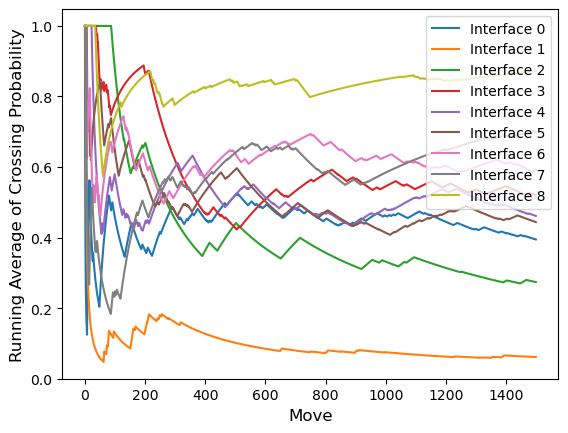

In [10]:
""" 1) Running Avereage of the Crossing Probability of Each Interface Ensemble """

ninterfaces = len(interfaces) - 1
allrunavg = [[] for i in range(ninterfaces)]

if pes_type == 4 and op_type == 2:
    for i in range(ninterfaces):
        crosslist = []
        
        for move in range(0,n_moves,1):
            val = np.min(allpaths[i][move][:,6])                                # tells us how far the specific path belonging to that specific interface has travelled

            if val < interfaces[i+1]:
                crosslist.append(1)
            else:
                crosslist.append(0)
            
        crosses = np.asarray(crosslist)                                         # counts the crosses for that interface into the neighboring i+1 interface

        # Calculate the running average

        for j in range(len(crosses)):
            runavg = np.mean(crosses[:j+1])
            # print(runavg)
            allrunavg[i].append(runavg)
else:
    for i in range(ninterfaces):
        crosslist = []
        
        for move in range(0,n_moves,1):
            val = np.max(allpaths[i][move][:,6])                                # tells us how far the specific path belonging to that specific interface has travelled

            if val > interfaces[i+1]:
                crosslist.append(1)
            else:
                crosslist.append(0)
            
        crosses = np.asarray(crosslist)                                         # counts the crosses for that interface into the neighboring i+1 interface

        # Calculate the running average

        for j in range(len(crosses)):
            runavg = np.mean(crosses[:j+1])
            # print(runavg)
            allrunavg[i].append(runavg)

# Plot Running Average of Crossing Probability of Each Interface Ensemble

for i in range(ninterfaces):
    plt.plot(range(0,n_moves),allrunavg[i][:], label='Interface {}'.format(i))
    plt.xlabel('Move', fontsize=12)
    plt.ylabel('Running Average of Crossing Probability', fontsize=12)
plt.legend(loc='upper right')
plt.show()


**Autocorrelation Graphs**: 

- The equation used for ACF calculation is:   

$$ \sum_{i=1}^{N-lag}{\frac{(\theta_{i}-\bar{\theta})(\theta_{i+lag}-\bar{\theta})}{\sum_{i=1}^{N}{(\theta_{i}-\bar{\theta}})^2}} $$ 


- What does this sampling check calculates? What does it tell you about your sampling?

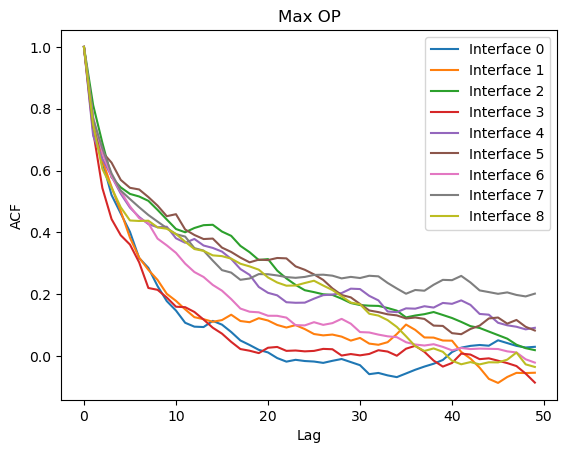

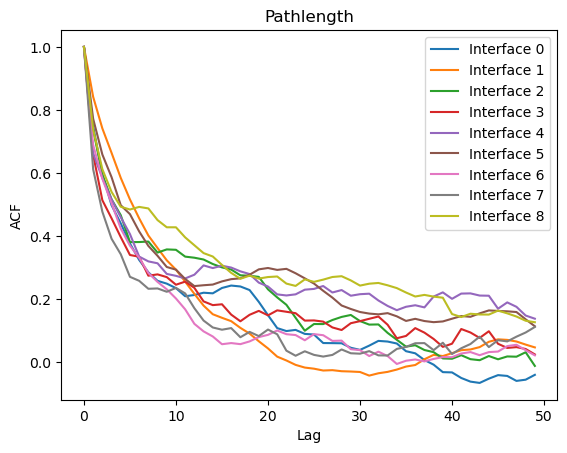

In [11]:
""" 2) Autocorrelation Graphs: a) Max OP, b) Pathlength, c) Indicator function, where it is 1 if path in i crosses i+1, 0 otherwise """

maxlag = 50                                             # Define your max lag
acf_m = [[] for i in range(ninterfaces)]
acf_p = [[] for i in range(ninterfaces)]
acf_i = [[] for i in range(ninterfaces)]

if pes_type == 4 and op_type == 2:
    
    for i in range(ninterfaces):
        maxOPvals = []                                      # List to store max OP values of each path of an interface ensemble
        pathlengthsvals = []                                # List to store pathlength values of each path of an interface ensemble
        indvals = []                                        # List to store indicator fn. values of each path of an interface ensemble

        start = 400                                         # You define what move the ACF starts at, this should correspond to where the running average crossing prob. converges
        
        # Gather information about each move for an interface ensemble
        for move in range(start,n_moves):                   
            maxOPvals.append(np.min(allpaths[i][move][:,6]))
            pathlengthsvals.append(len(allpaths[i][move]))
            
            ## EDIT THIS SO THAT YOU CAN USE INDICATOR FUNCTION SPECIFIED ABOVE AS A PROPERTY TO CALCULATE ACF ##

            # if XXXX:
            #     
            # else:
            #     
            
            ## END OF EDIT

        # Calculate ACF 
        
        # Get mean 
        maxop = np.asarray(maxOPvals)
        pl = np.asarray(pathlengthsvals)

        opavg = np.mean(maxop)
        plavg = np.mean(pl)

        # Get denominator
        denom_op = np.sum((maxop-opavg)**2)
        denom_pl = np.sum((pl-plavg)**2)

        # Get numerator 
        for lag in range(maxlag):
            sample = len(maxop) - lag                           # Number of samples that we're going to calculate ACF over
            
            acfmaxop = 0
            acfpl = 0
            acfind = 0

            for j in range(sample):
                numer_op = (maxop[j] - opavg)*(maxop[j+lag] - opavg)
                numer_pl = (pl[j] - plavg)*(pl[j+lag] - plavg)

                # Get ACF values
                acfmaxop += numer_op/denom_op
                acfpl += numer_pl/denom_pl

            acf_m[i].append(acfmaxop)
            acf_p[i].append(acfpl)
else:

    for i in range(ninterfaces):
        maxOPvals = []                                      # List to store max OP values of each path of an interface ensemble
        pathlengthsvals = []                                # List to store pathlength values of each path of an interface ensemble
        indvals = []                                        # List to store indicator fn. values of each path of an interface ensemble

        start = 400                                         # You define what move the ACF starts at, this should correspond to where the running average crossing prob. converges
        
        # Gather information about each move for an interface ensemble
        for move in range(start,n_moves):                   
            maxOPvals.append(np.max(allpaths[i][move][:,6]))
            pathlengthsvals.append(len(allpaths[i][move]))
            
            ## EDIT THIS SO THAT YOU CAN USE INDICATOR FUNCTION SPECIFIED ABOVE AS A PROPERTY TO CALCULATE ACF ##

            # if XXXX:
            #     
            # else:
            #     
            
            ## END OF EDIT

        # Calculate ACF 
        
        # Get mean 
        maxop = np.asarray(maxOPvals)
        pl = np.asarray(pathlengthsvals)

        opavg = np.mean(maxop)
        plavg = np.mean(pl)

        # Get denominator
        denom_op = np.sum((maxop-opavg)**2)
        denom_pl = np.sum((pl-plavg)**2)

        # Get numerator 
        for lag in range(maxlag):
            sample = len(maxop) - lag                           # Number of samples that we're going to calculate ACF over
            
            acfmaxop = 0
            acfpl = 0
            acfind = 0

            for j in range(sample):
                numer_op = (maxop[j] - opavg)*(maxop[j+lag] - opavg)
                numer_pl = (pl[j] - plavg)*(pl[j+lag] - plavg)

                # Get ACF values
                acfmaxop += numer_op/denom_op
                acfpl += numer_pl/denom_pl

            acf_m[i].append(acfmaxop)
            acf_p[i].append(acfpl)

# Plot ACF Graphs 

for i in range(ninterfaces):
    plt.plot(range(0,lag+1),acf_m[i], label='Interface {}'.format(i))
    plt.xlabel('Lag')
    plt.ylabel('ACF')
plt.title('Max OP')
plt.legend()
plt.show()

for i in range(ninterfaces):
    plt.plot(range(0,lag+1),acf_p[i], label='Interface {}'.format(i))
    plt.xlabel('Lag')
    plt.ylabel('ACF')
plt.title('Pathlength')
plt.legend()
plt.show()


## Answer Key

In [12]:
# """ Answer Key """

# maxlag = 50                                             # Define your max lag
# acf_m = [[] for i in range(ninterfaces)]
# acf_p = [[] for i in range(ninterfaces)]
# acf_i = [[] for i in range(ninterfaces)]

# if pes_type == 4 and op_type == 2:
#     for i in range(ninterfaces):
#         maxOPvals = []                                      # List to store max OP values of each path of an interface ensemble
#         pathlengthsvals = []                                # List to store pathlength values of each path of an interface ensemble
#         indvals = []                                        # List to store indicator fn. values of each path of an interface ensemble

#         start = 400                                         # You define what move the ACF starts at, this should correspond to where the running average crossing prob. converges
        
#         # Gather information about each move for an interface ensemble
#         for move in range(start,n_moves):                   
#             maxOPvals.append(np.min(allpaths[i][move][:,6]))
#             pathlengthsvals.append(len(allpaths[i][move]))
            
#             if np.min(allpaths[i][move][:,6]) < interfaces[i+1]:
#                 indvals.append(1)
#             else:
#                 indvals.append(0)

#         # Calculate ACF 
        
#         # Get mean 
#         maxop = np.asarray(maxOPvals)
#         pl = np.asarray(pathlengthsvals)
#         ind = np.asarray(indvals)

#         opavg = np.mean(maxop)
#         plavg = np.mean(pl)
#         indavg = np.mean(ind)

#         # Get denominator
#         denom_op = np.sum((maxop-opavg)**2)
#         denom_pl = np.sum((pl-plavg)**2)
#         denom_ind = np.sum((ind-indavg)**2)

#         # Get numerator 
#         for lag in range(maxlag):
#             sample = len(maxop) - lag                           # Number of samples that we're going to calculate ACF over
            
#             acfmaxop = 0
#             acfpl = 0
#             acfind = 0

#             for j in range(sample):
#                 numer_op = (maxop[j] - opavg)*(maxop[j+lag] - opavg)
#                 numer_pl = (pl[j] - plavg)*(pl[j+lag] - plavg)
#                 numer_ind = (ind[j] - indavg)*(ind[j+lag] - indavg)

#                 # Get ACF values
#                 acfmaxop += numer_op/denom_op
#                 acfpl += numer_pl/denom_pl

#                 if math.isnan(numer_ind/denom_ind):
#                     acfind += 0
#                 else:
#                     acfind += numer_ind/denom_ind

#             acf_m[i].append(acfmaxop)
#             acf_p[i].append(acfpl)
#             acf_i[i].append(acfind)

# else:

#     for i in range(ninterfaces):
#         maxOPvals = []                                      # List to store max OP values of each path of an interface ensemble
#         pathlengthsvals = []                                # List to store pathlength values of each path of an interface ensemble
#         indvals = []                                        # List to store indicator fn. values of each path of an interface ensemble

#         start = 400                                         # You define what move the ACF starts at, this should correspond to where the running average crossing prob. converges
        
#         # Gather information about each move for an interface ensemble
#         for move in range(start,n_moves):                   
#             maxOPvals.append(np.max(allpaths[i][move][:,6]))
#             pathlengthsvals.append(len(allpaths[i][move]))
            
#             if np.max(allpaths[i][move][:,6]) > interfaces[i+1]:
#                 indvals.append(1)
#             else:
#                 indvals.append(0)

#         # Calculate ACF 
        
#         # Get mean 
#         maxop = np.asarray(maxOPvals)
#         pl = np.asarray(pathlengthsvals)
#         ind = np.asarray(indvals)

#         opavg = np.mean(maxop)
#         plavg = np.mean(pl)
#         indavg = np.mean(ind)

#         # Get denominator
#         denom_op = np.sum((maxop-opavg)**2)
#         denom_pl = np.sum((pl-plavg)**2)
#         denom_ind = np.sum((ind-indavg)**2)

#         # Get numerator 
#         for lag in range(maxlag):
#             sample = len(maxop) - lag                           # Number of samples that we're going to calculate ACF over
            
#             acfmaxop = 0
#             acfpl = 0
#             acfind = 0

#             for j in range(sample):
#                 numer_op = (maxop[j] - opavg)*(maxop[j+lag] - opavg)
#                 numer_pl = (pl[j] - plavg)*(pl[j+lag] - plavg)
#                 numer_ind = (ind[j] - indavg)*(ind[j+lag] - indavg)

#                 # Get ACF values
#                 acfmaxop += numer_op/denom_op
#                 acfpl += numer_pl/denom_pl

#                 if math.isnan(numer_ind/denom_ind):
#                     acfind += 0
#                 else:
#                     acfind += numer_ind/denom_ind

#             acf_m[i].append(acfmaxop)
#             acf_p[i].append(acfpl)
#             acf_i[i].append(acfind)

# # Plot ACF Graphs 

# for i in range(ninterfaces):
#     plt.plot(range(0,lag+1),acf_m[i], label='Interface {}'.format(i))
#     plt.xlabel('Lag')
#     plt.ylabel('ACF')
# plt.legend()
# plt.title('Max OP')
# plt.show()

# for i in range(ninterfaces):
#     plt.plot(range(0,lag+1),acf_p[i], label='Interface {}'.format(i))
#     plt.xlabel('Lag')
#     plt.ylabel('ACF')
# plt.legend()
# plt.title('Pathlength')
# plt.show()

# for i in range(ninterfaces):
#     plt.plot(range(0,lag+1),acf_i[i], label='Interface {}'.format(i))
#     plt.xlabel('Lag')
#     plt.ylabel('ACF')
# plt.legend()
# plt.title('Indicator Fn.')
# plt.show()


**Crossing Probability Histogram for Each Interface Ensemble**:

- What does this sampling check calculates? What does it tell you about your sampling?

- What happens when you change the bin_width? How does bin_width relate to your OP and interface values?

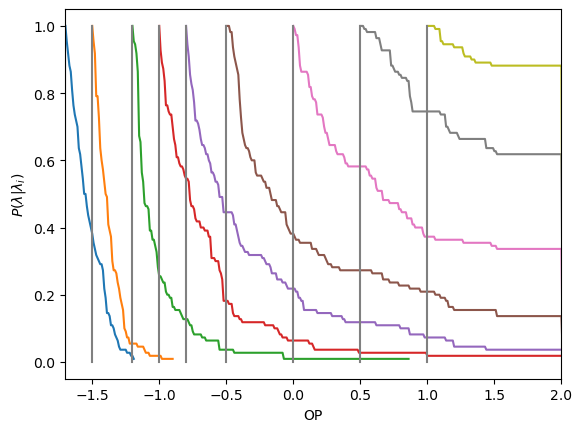

In [13]:
""" 3) Plot Crossing Probability Histogram for Each Interface Ensemble """

bin_width = 0.01 
max_bins = int((abs(interfaces[-1]-interfaces[0]))/bin_width)                        # number of lambdas between the first and last interface
counts = np.zeros((ninterfaces,max_bins))                                       # matrix to store crossing counts (for each lambda between the first and last interface)
                                                                                # size: interfaces x max_bins 

for i in range(ninterfaces):
    ndiscard = 10                                                               # this corresponds to the number of paths between each decorrelated sample/path
    for move in range(start,n_moves,ndiscard):
        
        if pes_type == 4 and op_type == 2:        
            val = np.min(allpaths[i][move][:,6])                                # gets the max op of this path, tells you how far this path has travelled
        else:
            val = np.max(allpaths[i][move][:,6])                                # gets the max op of this path, tells you how far this path has travelled
           
        nbin = int((abs(val-interfaces[i]))/bin_width)                          # tells us how many lambdas has this path crosses

        for j in range(min(nbin+1,max_bins)):
            counts[i][j] += 1                                                   # adds 1 for each lambda that this path crosses

# Get crossing probability histogram 

lambdas = [[] for i in range(ninterfaces)]
crossingprob = [[] for i in range(ninterfaces)]

for i in range(ninterfaces):
    for j in range(max_bins):
        if counts[i][j] > 0:
            
            if pes_type == 4 and op_type == 2:
                lambdas[i].append(interfaces[i]-j*bin_width)                    # this tracks the lambda corresponding to the crossing probability at that lambda
            else:
                lambdas[i].append(interfaces[i]+j*bin_width)                    # this tracks the lambda corresponding to the crossing probability at that lambda

            crossingprob[i].append(counts[i][j]/counts[i][0])                   # P(lambda|lambda_i), counts[i][0] is the total number of paths of that ensemble because 
                                                                                # all paths from this ensemble would have crossed that first interface
    
# Plot the histogram

for i in range(ninterfaces):
    plt.plot(lambdas[i],crossingprob[i], label='Interface {}'.format(i))
    plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(0,1,10), color='grey')
    plt.xlabel('OP')
    plt.ylabel('$P(\u03BB|\u03BB_{i})$')
# plt.legend()
plt.xlim(interfaces[0],interfaces[-1])
plt.show() 


## Continue RETIS simulation

- After the sampling check, perhaps, you have realized that you have not performed enough sampling. As such, you can continue to do so by specifying how many more moves you would like to run in **"continue_moves"**

In [14]:
continue_moves = 10000                                                           # how many more moves would you like to simulate?


if pes_type == 4 and op_type == 2:
    
    starttime2 = time.monotonic()

    for move in range(n_moves, n_moves+continue_moves):

        # Swap or Shoot? 
        ss = np.random.ranf()
        
        # Perform swap move
        if ss < 0.5: 

            # Decides on which ensemble pair switching we're doing
            ens_switch = np.random.ranf() 
            
            if ens_switch < 0.5: 
                print('Move = {} ; Performing Swap Move: 1-2, 3-4, 5-6, ...etc'.format(move), end='\r')
                
                # Accounting for the 1st interface, but first we need to check that it satisfies the ensemble criteria
                if np.where(allpaths[0][-1][:,6]<interfaces[0])[0].shape[0] == 0: 
                    reject_move = True
                    # print('Appending Rejected!')
                else:
                    allpaths[0].append(allpaths[0][-1])                             # append the previous 0th ensemble path to its own ensemble again because 
                                                                                    # there is no pair for this interface to swap with
                
                # For even number of interfaces:
                if (len(interfaces)-1)%2 == 0:                      
                    
                    # Accounting for the last interface 
                    if np.where(allpaths[-1][-1][:,6]<interfaces[-2])[0].shape[0] == 0: 
                        reject_move = True
                        # print('Appending Rejected!')
                    else:
                        allpaths[-1].append(allpaths[-1][-1])                       # append the previous path of the last ensemble to its own ensemble again because 
                                                                                    # there is no pair for this interface to swap with
                    
                    # Accounting for the rest of the interfaces
                    for i in np.arange(1,len(interfaces)-3,2):
                        # print('i = ', i)
                        path_1 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_2 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2's interface
                        n_cross_config = np.where(path_1[:,6]<interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_2)
                            allpaths[i+1].append(path_1)
                            
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_2)
                        
                # For odd number of interfaces:
                else:                              
                    for i in np.arange(1,len(interfaces)-1,2):
                        # print('i = ', i)
                        path_1 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_2 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # check if path 1 crosses path 2's interface
                        n_cross_config = np.where(path_1[:,6]<interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_2)
                            allpaths[i+1].append(path_1)
                        
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_2)
        
            else:
                print('Move = {} ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc'.format(move), end='\r')

                # For even number of interfaces: 
                if (len(interfaces)-1)%2 == 0:
                    for i in range(0,len(interfaces)-1,2):
                        # print('i = ' ,i)
                        path_0 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_1 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2 interface
                        n_cross_config = np.where(path_0[:,6]<interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_0)
                        
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_0)
                            allpaths[i+1].append(path_1)
                        
                # For odd number of interfaces:
                else: 
                    
                    # Accounting for the last interface:
                    if np.where(allpaths[-1][-1][:,6]<interfaces[-2])[0].shape[0] == 0: 
                        reject_move = True
                        # print('Appending Rejected!')
                    else: 
                        allpaths[-1].append(allpaths[-1][-1])                       # append the previous path of the last ensemble to its own ensemble again 
                                                                                    # because there is no pair for this interface to swap with
                    
                    # Accounting for the rest of the interfaces:
                    for i in range(0,len(interfaces)-2,2):
                        # print('i = ' ,i)
                        path_0 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_1 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2 interface
                        n_cross_config = np.where(path_0[:,6]<interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_0)

                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_0)
                            allpaths[i+1].append(path_1)
                        
        # Perform shooting move
        else: 
            print('Move = {} ; Performing Shoot Move                                '.format(move), end='\r')
            
            for i in np.arange(len(interfaces)-1):                                  # i signifies the interface that I'm looking at
                # print('i = ', i)
                path = allpaths[i][move-1]                                          # looks at the most current path of the TPE of interface i
                reject_move = False
                lmax = round((len(path) + 1)/np.random.uniform())                   # l max = maximum path length for flexible shooting 
                
                # Pick random shooting point 
                if i == 0:
                    minus_frame = find_config_minus(path, basinA)                   # find the index corresponding to interface i-1    
                    plus_frame = find_config_plus(path, interfaces[i+1])            # find the index corresponding to interface i+1 
                    index = np.random.randint(minus_frame,plus_frame)

                # Pick random shooting point between i-1 and i+1
                else:               
                    minus_frame = find_config_minus(path, interfaces[i-1])          # find the index corresponding to interface i-1    
                    plus_frame = find_config_plus(path, interfaces[i+1])            # find the index corresponding to interface i+1  
                    index = np.random.randint(minus_frame,plus_frame)

                # Perturb the momenta
                shoot_point = copy.deepcopy(path[index])                            # gives me 1 phase space point/config along the path
                shoot_point[2] += np.random.normal(0,sigma)                         # px
                shoot_point[3] += np.random.normal(0,sigma)                         # py
                trial_path = np.asarray([shoot_point])                              # new trial path after perturbing the momenta

                if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
                    # the if is testing to see if we want to use this new trial path (after momenta is perturbed) 
                    # before even shooting it
                    reject_move = True
                    # print('Shooting Move Rejected! Momenta Perturbation Failed!') 

                # Integrate backwards path if we have not rejected the move...
                if reject_move == False:
                    path_length = 1
                    trial_path[:,2] *=-1                                            # change px to the negative direction by * -1
                    trial_path[:,3] *=-1                                            # change py to the negative direction by * -1
                    trajstep = copy.deepcopy(trial_path[-1])                        # take the last config of trial path
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])                # calc op value for config

                    while op <= basinA:
                        trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)   # ld.vv_step(x,y,px,py,fx,fy,dt,beta,gamma)
                        op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                        trajstep = np.append(trajstep,[op],axis=0)
                        trial_path = np.append(trial_path,[trajstep],axis=0)
                        path_length +=1

                        # Reject if the maximum path length is exceeded
                        if path_length > lmax:
                            reject_move = True
                            # print('Shooting Move Rejected! Pathlength limit!')
                            break

                        # Reject if the backward path segment goes to B
                        if op <= basinB:
                            reject_move = True
                            # print('Shooting Move Rejected! Backward segment reaches B!')
                            break

                # Forward shooting             
                if reject_move == False: 
                    trial_path = np.flip(trial_path,axis=0)                          # flip it from the back to front of this trial path (because it was shooting backwards), 
                                                                                    # so we flip so that the last config we extract from here will be where we'll use to shoot forward
                    trial_path[:,2] *=-1
                    trial_path[:,3] *=-1
                    trajstep = copy.deepcopy(trial_path[-1])
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
        
                    while op < basinA and op > basinB:                               # this is so that it restricts forward shooting to either end in A or B

                        nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
                        trajstep = nextstep
                        op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                        trajstep = np.append(trajstep,[op],axis=0)
                        trial_path = np.append(trial_path,[trajstep],axis=0)
                        path_length +=1
                        
                        if path_length > lmax:
                            reject_move = True
                            # print('Shooting Move Rejected! Pathlength Limit!')
                            break

                # Final chance to reject a path (because no crossing of interface i)
                if np.where(trial_path[:,6]<interfaces[i])[0].shape[0] == 0:        # np.where(condition)[0] tells you which array or which path satisfies this condition and 
                                                                                    # the .shape[0] how many configs satisfy this, if 0, then we never cross the interface
                    reject_move = True
                    # print('Shooting Move Rejected! Did not cross its own interface!')
                
                # If we DON'T reject, then path becomes trial path
                if reject_move == False:
                    # print('Shooting Move Accepted!')
                    path = trial_path
                
                # Append current accepted path to its corresponding path ensemble
                allpaths[i].append(path)                                            # all paths contains all paths per each interface - i is to signify which interface 
                                                                                    # ensemble we're looking at. So allpaths[0] will contain all paths that cross interface lambda 0

    endtime = time.monotonic()

    print('Total simulation time for {} moves: {:10.3f} s                           '.format(continue_moves,endtime-starttime2))

# For the other types of PES and OP combos
else:
    starttime2 = time.monotonic()

    for move in range(n_moves, n_moves+continue_moves):

        # Swap or Shoot? 
        ss = np.random.ranf()
        
        # Perform swap move
        if ss < 0.5: 

            # Decides on which ensemble pair switching we're doing
            ens_switch = np.random.ranf() 
            
            if ens_switch < 0.5: 
                print('Move = {} ; Performing Swap Move: 1-2, 3-4, 5-6, ...etc'.format(move), end='\r')
                
                # Accounting for the 1st interface, but first we need to check that it satisfies the ensemble criteria
                if np.where(allpaths[0][-1][:,6]>interfaces[0])[0].shape[0] == 0: 
                    reject_move = True
                    # print('Appending Rejected!')
                else:
                    allpaths[0].append(allpaths[0][-1])                             # append the previous 0th ensemble path to its own ensemble again because 
                                                                                    # there is no pair for this interface to swap with
                
                # For even number of interfaces:
                if (len(interfaces)-1)%2 == 0:                      
                    
                    # Accounting for the last interface 
                    if np.where(allpaths[-1][-1][:,6]>interfaces[-2])[0].shape[0] == 0: 
                        reject_move = True
                        # print('Appending Rejected!')
                    else:
                        allpaths[-1].append(allpaths[-1][-1])                       # append the previous path of the last ensemble to its own ensemble again because 
                                                                                    # there is no pair for this interface to swap with
                    
                    # Accounting for the rest of the interfaces
                    for i in np.arange(1,len(interfaces)-3,2):
                        # print('i = ', i)
                        path_1 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_2 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2's interface
                        n_cross_config = np.where(path_1[:,6]>interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_2)
                            allpaths[i+1].append(path_1)
                            
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_2)
                        
                # For odd number of interfaces:
                else:                              
                    for i in np.arange(1,len(interfaces)-1,2):
                        # print('i = ', i)
                        path_1 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_2 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # check if path 1 crosses path 2's interface
                        n_cross_config = np.where(path_1[:,6]>interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_2)
                            allpaths[i+1].append(path_1)
                        
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_2)
        
            else:
                print('Move = {} ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc'.format(move), end='\r')

                # For even number of interfaces: 
                if (len(interfaces)-1)%2 == 0:
                    for i in range(0,len(interfaces)-1,2):
                        # print('i = ' ,i)
                        path_0 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_1 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2 interface
                        n_cross_config = np.where(path_0[:,6]>interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_0)
                        
                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_0)
                            allpaths[i+1].append(path_1)
                        
                # For odd number of interfaces:
                else: 
                    
                    # Accounting for the last interface:
                    if np.where(allpaths[-1][-1][:,6]>interfaces[-2])[0].shape[0] == 0: 
                        reject_move = True
                        # print('Appending Rejected!')
                    else: 
                        allpaths[-1].append(allpaths[-1][-1])                       # append the previous path of the last ensemble to its own ensemble again 
                                                                                    # because there is no pair for this interface to swap with
                    
                    # Accounting for the rest of the interfaces:
                    for i in range(0,len(interfaces)-2,2):
                        # print('i = ' ,i)
                        path_0 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                        path_1 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                        
                        # Check if path 1 crosses path 2 interface
                        n_cross_config = np.where(path_0[:,6]>interfaces[i+1])[0].shape[0]

                        if n_cross_config != 0:                                     # if the swap is successful, do the swap
                            # print('Successful Swap!')
                            allpaths[i].append(path_1)
                            allpaths[i+1].append(path_0)

                        else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                            # print('Unsuccessful Swap!')
                            allpaths[i].append(path_0)
                            allpaths[i+1].append(path_1)
                        
        # Perform shooting move
        else: 
            print('Move = {} ; Performing Shoot Move                                '.format(move), end='\r')
            
            for i in np.arange(len(interfaces)-1):                                  # i signifies the interface that I'm looking at
                # print('i = ', i)
                path = allpaths[i][move-1]                                          # looks at the most current path of the TPE of interface i
                reject_move = False
                lmax = round((len(path) + 1)/np.random.uniform())                   # l max = maximum path length for flexible shooting 
                
                # Pick random shooting point 
                if i == 0:
                    minus_frame = find_config_minus(path, basinA)                   # find the index corresponding to interface i-1    
                    plus_frame = find_config_plus(path, interfaces[i+1])            # find the index corresponding to interface i+1 
                    index = np.random.randint(minus_frame,plus_frame)

                # Pick random shooting point between i-1 and i+1
                else:               
                    minus_frame = find_config_minus(path, interfaces[i-1])          # find the index corresponding to interface i-1    
                    plus_frame = find_config_plus(path, interfaces[i+1])            # find the index corresponding to interface i+1  
                    index = np.random.randint(minus_frame,plus_frame)

                # Perturb the momenta
                shoot_point = copy.deepcopy(path[index])                            # gives me 1 phase space point/config along the path
                shoot_point[2] += np.random.normal(0,sigma)                         # px
                shoot_point[3] += np.random.normal(0,sigma)                         # py
                trial_path = np.asarray([shoot_point])                              # new trial path after perturbing the momenta

                if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
                    # the if is testing to see if we want to use this new trial path (after momenta is perturbed) 
                    # before even shooting it
                    reject_move = True
                    # print('Shooting Move Rejected! Momenta Perturbation Failed!') 

                # Integrate backwards path if we have not rejected the move...
                if reject_move == False:
                    path_length = 1
                    trial_path[:,2] *=-1                                            # change px to the negative direction by * -1
                    trial_path[:,3] *=-1                                            # change py to the negative direction by * -1
                    trajstep = copy.deepcopy(trial_path[-1])                        # take the last config of trial path
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])                # calc op value for config

                    while op >= basinA:
                        trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)   # ld.vv_step(x,y,px,py,fx,fy,dt,beta,gamma)
                        op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                        trajstep = np.append(trajstep,[op],axis=0)
                        trial_path = np.append(trial_path,[trajstep],axis=0)
                        path_length +=1

                        # Reject if the maximum path length is exceeded
                        if path_length > lmax:
                            reject_move = True
                            # print('Shooting Move Rejected! Pathlength limit!')
                            break

                        # Reject if the backward path segment goes to B
                        if op >= basinB:
                            reject_move = True
                            # print('Shooting Move Rejected! Backward segment reaches B!')
                            break

                # Forward shooting             
                if reject_move == False: 
                    trial_path = np.flip(trial_path,axis=0)                          # flip it from the back to front of this trial path (because it was shooting backwards), 
                                                                                    # so we flip so that the last config we extract from here will be where we'll use to shoot forward
                    trial_path[:,2] *=-1
                    trial_path[:,3] *=-1
                    trajstep = copy.deepcopy(trial_path[-1])
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
        
                    while op > basinA and op < basinB:                               # this is so that it restricts forward shooting to either end in A or B

                        nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
                        trajstep = nextstep
                        op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                        trajstep = np.append(trajstep,[op],axis=0)
                        trial_path = np.append(trial_path,[trajstep],axis=0)
                        path_length +=1
                        
                        if path_length > lmax:
                            reject_move = True
                            # print('Shooting Move Rejected! Pathlength Limit!')
                            break

                # Final chance to reject a path (because no crossing of interface i)
                if np.where(trial_path[:,6]>interfaces[i])[0].shape[0] == 0:        # np.where(condition)[0] tells you which array or which path satisfies this condition and 
                                                                                    # the .shape[0] how many configs satisfy this, if 0, then we never cross the interface
                    reject_move = True
                    # print('Shooting Move Rejected! Did not cross its own interface!')
                
                # If we DON'T reject, then path becomes trial path
                if reject_move == False:
                    # print('Shooting Move Accepted!')
                    path = trial_path
                
                # Append current accepted path to its corresponding path ensemble
                allpaths[i].append(path)                                            # all paths contains all paths per each interface - i is to signify which interface 
                                                                                    # ensemble we're looking at. So allpaths[0] will contain all paths that cross interface lambda 0

    endtime = time.monotonic()

    print('Total simulation time for {} moves: {:10.3f} s                           '.format(continue_moves,endtime-starttime2))

n_moves = n_moves+continue_moves

Total simulation time for 10000 moves:    690.275 s                           


## Visualize crossing histogram again

11500


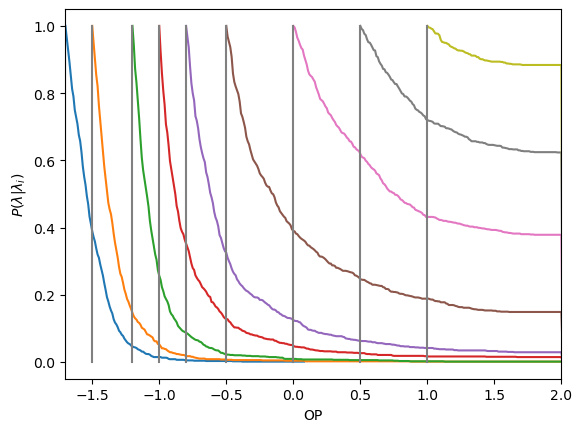

In [15]:
""" 3) Plot Crossing Probability Histogram for Each Interface Ensemble """

bin_width = 0.01 
max_bins = int((abs(interfaces[-1]-interfaces[0]))/bin_width)                        # number of lambdas between the first and last interface
counts = np.zeros((ninterfaces,max_bins))                                       # matrix to store crossing counts (for each lambda between the first and last interface)
                                                                                # size: interfaces x max_bins 
print(n_moves)
for i in range(ninterfaces):
    ndiscard = 10                                                               # this corresponds to the number of paths between each decorrelated sample/path
    for move in range(start,n_moves,ndiscard):
        
        if pes_type == 4 and op_type == 2:        
            val = np.min(allpaths[i][move][:,6])                                # gets the max op of this path, tells you how far this path has travelled
        else:
            val = np.max(allpaths[i][move][:,6])                                # gets the max op of this path, tells you how far this path has travelled
           
        nbin = int((abs(val-interfaces[i]))/bin_width)                          # tells us how many lambdas has this path crosses

        for j in range(min(nbin+1,max_bins)):
            counts[i][j] += 1                                                   # adds 1 for each lambda that this path crosses

# Get crossing probability histogram 

lambdas = [[] for i in range(ninterfaces)]
crossingprob = [[] for i in range(ninterfaces)]

for i in range(ninterfaces):
    for j in range(max_bins):
        if counts[i][j] > 0:
            
            if pes_type == 4 and op_type == 2:
                lambdas[i].append(interfaces[i]-j*bin_width)                    # this tracks the lambda corresponding to the crossing probability at that lambda
            else:
                lambdas[i].append(interfaces[i]+j*bin_width)                    # this tracks the lambda corresponding to the crossing probability at that lambda

            crossingprob[i].append(counts[i][j]/counts[i][0])                   # P(lambda|lambda_i), counts[i][0] is the total number of paths of that ensemble because 
                                                                                # all paths from this ensemble would have crossed that first interface
    
# Plot the histogram

for i in range(ninterfaces):
    plt.plot(lambdas[i],crossingprob[i], label='Interface {}'.format(i))
    plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(0,1,10), color='grey')
    plt.xlabel('OP')
    plt.ylabel('$P(\u03BB|\u03BB_{i})$')
# plt.legend()
plt.xlim(interfaces[0],interfaces[-1])
plt.show() 


## Plot the paths collected at each interface

In [16]:
# # Plot sampled paths from each interface
# skip = 100

# for i in range(len(interfaces) - 1):
#     plt.figure()

#     plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
        
#     for j in range(1,len(allpaths[i]),skip):
#         plt.plot(allpaths[i][j][:,0],allpaths[i][j][:,1])                                   # allpaths[i] tells you the interface ensemble you're in, 
#                                                                                             # [j] tells you a specific path in that ensemble, [:,0/1] takes 
#                                                                                             # all the x/y values of the paths in i
    
#     # Plot basin boundaries

#     if op_type == 1:
#         plt.plot(np.linspace(basinA,basinA,10),np.linspace(min(y_vec),max(y_vec),10),color='r', label='Basin A')
#         plt.plot(np.linspace(basinB,basinB,10),np.linspace(min(y_vec),max(y_vec),10),color='b', label='Basin B')
#     elif op_type == 2:
#         plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(basinA,basinA,10),color='r', label='Basin A')
#         plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(basinB,basinB,10),color='b', label='Basin B')
#     else:
#         xplot = np.linspace(min(x_vec),max(x_vec),10)
#         yplmax = basinB - xplot
#         yplmin = basinA - xplot
#         plt.plot(xplot,yplmin,color='r', label='Basin A')
#         plt.plot(xplot,yplmax,color='b', label='Basin B')
        
#     # Plot interfaces
#     if op_type == 1:
#         plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(min(y_vec),max(y_vec),10), color='grey')
#     elif op_type == 2:
#         plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(interfaces[i],interfaces[i],10), color='grey')
#     else:
#         xplot = np.linspace(min(x_vec),max(x_vec),10)
#         yplot = interfaces[i]-xplot
#         plt.plot(xplot,yplot, color='grey')    
    
#     cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
#     cbar.set_ticks([])
#     cbar.set_label(label = 'Energy', size=12)
#     plt.legend()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.show

## Visualize density of configurations sampled

In [17]:
# from matplotlib.colors import Normalize 
# from scipy.interpolate import interpn

# throwout = 600                                                          # moves to discard to get the system to equilibrate

# x = []
# y = [] 

# for l in range(len(interfaces)-1):
#     for i in range(len(allpaths[l][throwout::])):
        
#         # Let's only look at transition paths
#         if np.where(allpaths[l][i+throwout][:,6] <= basinA)[0].shape[0] == 0 or np.where(allpaths[l][i+throwout][:,6] >= basinB)[0].shape[0] == 0:
#             continue
#         else:
#             for j in range(len(allpaths[l][i])): 
#                 x.append(allpaths[l][i][j][0])
#                 y.append(allpaths[l][i][j][1])
# y = np.asarray(y)
# x = np.asarray(x)


# bins = 20
# sort = True
# fig , ax = plt.subplots(figsize=(8,6))
# data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
# z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

# #To be sure to plot all data
# z[np.where(np.isnan(z))] = 0.0

# # Sort the points by density, so that the densest points are plotted last
# if sort :
#     idx = z.argsort()
#     x, y, z = x[idx], y[idx], z[idx]

# # Plot the density of states visited
# points = 100000              # our data is quite large, so we'll do this to avoid crashes when plotting
# ax.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3], colors='silver')
# ax.scatter( x[::int(len(x)/points)], y[::int(len(y)/points)], c=z[::int(len(z)/points)], s=3, cmap = 'jet', alpha = 0.1)

# norm = Normalize(vmin = np.min(z), vmax = np.max(z))
# cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = 'jet'), ax=ax)
# cbar.ax.set_ylabel('Density')         

# ax.set_xlabel('x',fontsize=15)
# ax.set_ylabel('y',fontsize=15)
# ax.tick_params(axis='both',labelsize=12)
# plt.show()

## Calculate the flux, crossing probabilities and rate constant

- ## Equations: 
    $$ k_{AB} = \Phi_{\lambda_{0}} * P(\lambda_{B}|\lambda_{A}) = \Phi_{\lambda_{0}} * \prod_{i=0}^{N_{interface}}{P(\lambda_{i+1}|\lambda_{i})} $$
    $$ Crossing\ Probability = P(\lambda_{B}|\lambda_{A}) = \prod_{i=0}^{N_{interface}}{P(\lambda_{i+1}|\lambda_{i})} $$
    $$ Flux\ through\ the\ 1st\ interface = \Phi_{\lambda_{0}} = \frac{n_{crosses,\lambda_{0}}}{n_{\ tot paths,\ basin}} $$

In [20]:
# Calculate flux

flux = n_cross_flux/(basinlen*dt)
print("Flux through first interface: {}\n".format(flux))
# print("Number of first crossings: {}\n".format(n_cross_flux))

# Calculate Rate
cross_probs = 1

for i in range(ninterfaces):
    for j in lambdas[i]:
        if j == interfaces[i+1]:
            index = np.where(np.array(lambdas[i])==j)[0][0]
            # print(index, crossingprob[i][index])
            cross_probs *= crossingprob[i][index]

ratek = flux*cross_probs                                    # flux from the first crossing * product of crossing probability of all interface
print("Rate Constant: {:e}".format(ratek))
np.savetxt('ratek-AB.txt',[ratek])


Flux through first interface: 0.122

Rate Constant: 3.130697e-05


## Exercises you can try!

**Exercise 1.** For a pes_type 1, what would happen if you were to use less number of interfaces? What would happen to the crossing probability? Why? 

**Exercise 2.**  For pes_type 2, what do you notice if you were to use an OP where OP = x+y, instead of OP = x? What changes do you see with the crossing probability? Rates? Sampling quality?

        **Remember: When changing your pes_type, you must be cautious about where you define your basins, initial configuration and the values you assign the interfaces (aka where you place them). 

**Exercise 3.** Path sampling is supposed to be an OP independent enhanced sampling method. Do you think this is true? Try using OP = x for pes_type = 4 vs using OP = y. 


# Beyond Sampling!!!
    Yay

# Perform WHAM to stitch all crossing probability 

Reading in trajectories...
Complete.
Performing WHAM...


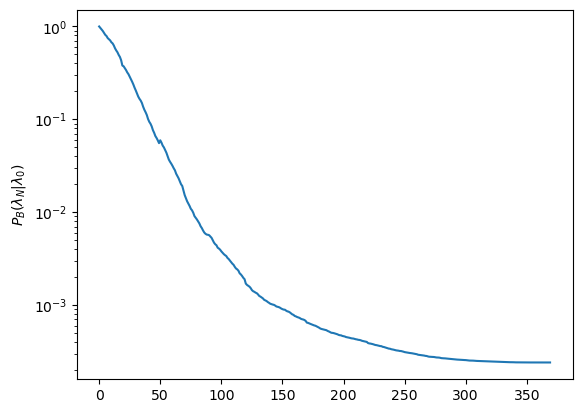

P(B|lambda_0): 2.4051e-04


In [23]:
bin_width = 0.01

ninterfaces = len(interfaces) - 1
max_bins = int((interfaces[-1]-interfaces[0])/bin_width)
counts = np.zeros((max_bins,ninterfaces))

print("Reading in trajectories...")

for interface in range(ninterfaces):
    start = 400
    ndiscard = 10
    for move in range(start,n_moves,ndiscard):

        val = np.max(allpaths[interface][move][:,6])
        sbin = int((interfaces[interface]-interfaces[0])/bin_width)
        ebin = int((val-interfaces[0])/bin_width)
        
        for i in range(sbin,min(ebin+1,max_bins)):
            counts[i][interface] += 1 

print("Complete.")

probs = counts/np.max(counts,axis=0)
# find where prob<0.03 and set counts to zero
vals,ints = np.where(probs < 0.02)
counts[vals,ints] = 0
probs = counts/np.max(counts,axis=0)
# did a path from ensemble i reach lambda>lambda_i?
unweighting = (counts > 0).astype(int)
# total number of paths to reach a given lambda
sum_k_Hk_Q = np.sum(counts,axis=1)
# number of contributions each interface makes to all values of lambda>lambda_i
n_entries = np.sum(counts,axis=0)
# weight contributions of difference interfaces at each lambda
weighted_counts = n_entries*unweighting

guess_Z_data = [1.0]

# for each interface
for i in range(1,counts.shape[1]):
    # lambda values where prob=1 (lambda_i)
    index = np.where(probs[:,i] == 1.0)[0][0]
    # previous interface prob times P(lambda_i+1|lambda_i)
    guess_Z_data.append(guess_Z_data[i-1]*probs[index][i-1])

lnZ_old = np.log(np.asarray(guess_Z_data))

Z_new = np.zeros(lnZ_old.shape)
diff=1.

# minimize difference between lnZ old and new

print("Performing WHAM...")
while diff > 0.001:
    Z_old = np.exp(lnZ_old)
    reciprocal_Z_old = (1.0 / Z_old)
    
    # for each interface
    for i in range(weighted_counts.shape[1]):
        
        # which lambda are reached by interface i?
        w_i = unweighting[:,i]
        
        # total number of paths to reach w_i set from all paths
        numerator_byQ = np.multiply(w_i, sum_k_Hk_Q)
        sum_over_Z_byQ = weighted_counts.dot(reciprocal_Z_old)
        with np.errstate(divide='ignore', invalid='ignore'):
            addends_k = np.divide(numerator_byQ, sum_over_Z_byQ)
        Z_new[i] = np.nansum(addends_k)
    lnZ_new = np.log(Z_new)
    diff = sum(abs(lnZ_old - lnZ_new))
    lnZ_old = lnZ_new - lnZ_new[0]

Z_old = np.exp(lnZ_old)
Z = Z_old
Z0_over_Zi = Z[0] / Z
sum_w_over_Z = np.sum(weighted_counts*Z0_over_Zi,axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    output = sum_k_Hk_Q / sum_w_over_Z
result = output/np.max(output)

# for i in range(1,counts.shape[1]):
#     fpp = open(f"wtd-hist-{i}.txt","w")
#     index = np.where(probs[:,i] == 1.0)[0][0]
#     prop = result[index]
#     for j in np.where(probs[:,i] > 0)[0]:
#         fpp.write("{} {}\n".format(bin_width*j+0.5+interfaces[0],prop*probs[j,i]))
#     fpp.close()

fop = open("wham-AB.txt","w")

for i in range(len(result)):
    fop.write("{}  {}\n".format(bin_width*i+interfaces[0],result[i]))

plt.yscale("log")
plt.ylabel(r'$P_B({\lambda_N|\lambda_0})$')
plt.plot(result)
plt.show()

print("P(B|lambda_0): %8.4e" % result[-1])

# Get path weight ($W_A$)

In [24]:
# Calculate ensemble weights 

op = np.loadtxt("wham-AB.txt",usecols=0)
probhist = np.loadtxt("wham-AB.txt",usecols=1)
prob = 0 
wbar = []
wbar_iA = []
intf = []

for l in op:

    # get index of the order parameter value = l 
    index = (op.tolist()).index(l) 
    
    # loop over the interface so we know where l is bounded between 
    for i in range(ninterfaces):
        
        # this if statement tells me which sum from j=1 to i of P(lmbda|lmbda_j) to care about 
        # looking at equation A4, the step function is telling me lambda is not between i and i+1, then that sum won't matter
        if l > interfaces[i] and l < interfaces[i+1] or l == interfaces[i]:

           # loop over each interface because we want sum from j=1 to i of P(lmbda|lmbda_j)
           # ex: P(lmbda|lmbda_1)+P(lmbda|lmbda_2)+P(lmbda|lmbda_3)...+P(lmbda|lmbda_N) where N is last interface
           for j in range(i+1):
               prob += probs[index][j] 
           intf.append(i)
           

    wbar.append(probhist[index]/prob)
    prob = 0


# get wbar_i (which is the ensemble weights) now!

fens = open("ensemble-weights-AB.txt","a")
for i in range(ninterfaces):
    index = np.where(interfaces[i] == np.round(op,2))
    # print(index[0])
    wbar_iA.append(wbar[index[0][0]])
    # wbar[index[0][0]] is the same as [index[0][i]] so we only need to pick one for the ensemble weight
    fens.write("{}\n".format(wbar_iA[i]))
fens.close()

# $p_B$ projection using RPE method (Bolhius et al., 2010, JCP)

## Equation 16 gives:
$ \bar{p}_{B}(q) = \frac{\int{Dx^L\sum_{k=0}^{L}{\prod_{i=1}^{m}{\delta(q^{(i)}(x_k)-q^{(i)})}}P_A[x^L]h_B(x_L)}}{\int{Dx^L\sum_{k=0}^{L}{\prod_{i=1}^{m}{\delta(q^{(i)}(x_k)-q^{(i)})}}P_A[x^L]}} $

## Equation A21 and A22 gives:
$ P_A[x^L] = \sum_{j=1}^{n-1}{P_{A\lambda_j}[x^L] \times W^{A}[x^L]}$ 

In [31]:
# # Performing projection onto 1 CV

# pB = []
# ens_weight = np.loadtxt('ensemble-weights-AB.txt')
# n, d, qval = [], [], []

# dq = 0.1                                                               # bin size
# for q in tqdm(np.arange(-2,2,dq)):                                  # then this is the second look to calculate pB projection over this bin (2D projection)
#                                                                     # so we need 2 OPs
#     opcount = 0
#     count = 0
#     sumprob = 0
#     numer = 0
#     denom = 0

#     for i in range(ninterfaces):
#         start = 500
#         ndiscard = 10
#         for move in range(start, n_moves, ndiscard):
            
#             # 1) bin the OP values first 
#             # this tells me how many OP value of this 1 path falls into this bin                
#             opindex = np.where((allpaths[i][move][:,6] > q) & (allpaths[i][move][:,6] <= q+dq))
#             # print(opindex)
#             opcount = np.sum(allpaths[i][move][opindex[0],6])                                 # used in 1D projection case

#             # 2) calculate P_A[x^L]
#                 # Logic: 
#                 # so for a given path "allpaths[interface][move]", we want to search if it has OP that crosses the interfaces
#                 # so if i find the max OP it reaches, then I can just say if this OP is less than interfaces[i], then use the WHAM prob "probhist[interface]" at that interface[i]
#                 # and iteratively add until we finish looping through interfaces [i]
#             val = np.max(allpaths[i][move][:,6])
#             for j in range(ninterfaces):
#                 if val >= interfaces[j]:
#                     # print(j)                                      # j here is the interface that our path gets to travel the furthes to
                    
#                     # find wham probability of path getting to interface[j]/lambda_j
#                     index = np.where(interfaces[j] == np.round(op,2)) 
#                     sumprob += probhist[index[0][0]]
#                     wA = ens_weight[j]

#                 # get path weights
#             # weightdata = np.loadtxt('weightpath-'+str(i)+'.txt')
#             # index = np.where(weightdata[:,1] == move)
#             # wA = weightdata[index[0][0],2]

#                 # get P_A[x^L]
#             pA = wA*sumprob

#             # 3) Get numerator and denominator of pB projection equation and calculate pB
                
#                 # filter only AB paths
#             if val >= interfaces[-1]:   
#                 numer += pA*opcount
#             else:
#                 numer += 0
#                 # print(numer)
            
#             # get all paths
#             denom += pA*opcount

#     n.append(numer)
#     d.append(denom)
#     qval.append(q)
#     pB.append(numer/denom)

# np.savetxt('pBprojection-ABpaths-1CV.txt', np.transpose((qval,pB,n,d)))


100%|██████████| 40/40 [00:29<00:00,  1.37it/s]
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e')

In [39]:
# Performing projection onto 2 CV

pB, n, d, qval, yval = [], [], [], [], []
ens_weight = np.loadtxt('ensemble-weights-AB.txt')

dq = 0.1                                                               # bin size
for y in tqdm(np.arange(-2,2,dq)):                                      # this is the first look to calculate pB projection over this bin
    for q in tqdm(np.arange(-2,2,dq)):                                  # then this is the second look to calculate pB projection over this bin (2D projection)
                                                                        # so we need 2 OPs
        opcount = 0
        count = 0
        sumprob = 0
        numer = 0
        denom = 0

        for i in range(ninterfaces):
            start = 500
            ndiscard = 10
            for move in range(start, n_moves, ndiscard):
                
                # 1) bin the OP values first 
                # this tells me how many OP value of this 1 path falls into this bin                
                opindex = np.where((allpaths[i][move][:,6] > q) & (allpaths[i][move][:,6] <= q+dq) & (allpaths[i][move][:,1] > y) & (allpaths[i][move][:,1] <= y+dq))
                # print(opindex)
                # opcount = np.sum(allpaths[i][move][op1index[0],6])                                 # used in 1D projection case
                opcount = np.sum(allpaths[i][move][opindex[0],6]*allpaths[i][move][opindex[0],1])       # used in 2D projection case

                # 2) calculate P_A[x^L]
                    # Logic: 
                    # so for a given path "allpaths[interface][move]", we want to search if it has OP that crosses the interfaces
                    # so if i find the max OP it reaches, then I can just say if this OP is less than interfaces[i], then use the WHAM prob "probhist[interface]" at that interface[i]
                    # and iteratively add until we finish looping through interfaces [i]
                val = np.max(allpaths[i][move][:,6])
                for j in range(ninterfaces):
                    if val >= interfaces[j]:
                        # print(j)                                      # j here is the interface that our path gets to travel the furthes to
                        
                        # find wham probability of path getting to interface[j]/lambda_j
                        index = np.where(interfaces[j] == np.round(op,2)) 
                        sumprob += probhist[index[0][0]]
                        wA = ens_weight[j]

                    # get path weights
                # weightdata = np.loadtxt('weightpath-'+str(i)+'.txt')
                # index = np.where(weightdata[:,1] == move)
                # wA = weightdata[index[0][0],2]

                    # get P_A[x^L]
                pA = wA*sumprob

                # 3) Get numerator and denominator of pB projection equation and calculate pB
                    
                    # filter only AB paths
                if val >= interfaces[-1]:   
                    numer += pA*opcount
                else:
                    numer += 0
                    # print(numer)
                
                # get all paths
                denom += pA*opcount
        
        n.append(numer)
        d.append(denom)
        qval.append(q)
        yval.append(y)
        pB.append(numer/denom)

np.savetxt('pBprojection-ABpaths-2CV.txt',np.transpose((qval,yval,pB,n,d)))


  0%|          | 0/40 [00:00<?, ?it/s]/var/folders/v6/2z_d669j62l06tpwdq84wcfh0000gn/T/ipykernel_99336/934420043.py:67: RuntimeWarning: invalid value encountered in double_scalars
  pB.append(numer/denom)
100%|██████████| 40/40 [21:22<00:00, 32.07s/it]


# Plot the $p_B$ projection

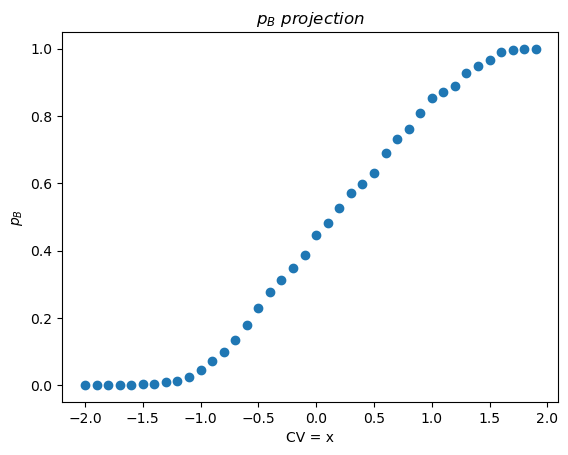

In [27]:
# # 1D Case

# plt.scatter(np.arange(-2,2,dq),pB)
# plt.ylabel(r'$p_B$')
# plt.xlabel('CV = x')
# plt.title(r'$ p_B\ projection$')
# plt.show()


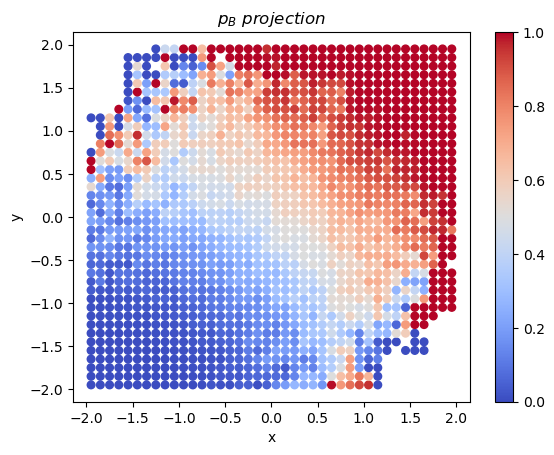

In [40]:
# 2D Case 
hist = [[], [], []]

i = 0

for y in np.arange(-2,2,dq):   
    for q in np.arange(-2,2,dq): 
        hist[0].append(q+dq*0.5)
        hist[1].append(y+dq*0.5)
        hist[2].append(pB[i])
        i += 1

# plt.hexbin(hist[0],hist[1], C = hist[2], cmap='coolwarm', gridsize=20)
# plt.hist2d(hist[0],hist[1], weights = hist[2], cmap='coolwarm')
plt.scatter(hist[0],hist[1], c = hist[2], cmap='coolwarm',s=30)
plt.colorbar()
plt.ylabel('y')
# plt.ylabel(r'$p_B$')
plt.xlabel('x')
plt.title(r'$ p_B\ projection$')
plt.show()